# New York City Taxi Fare Prediction with Random Forest

Please download data at [New York City Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data)

In [1]:
import numpy as np 
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import inspect
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from joblib import dump, load
import time

## Dataset input

Read a subset of the training dataset since it's very big, and takes long time to read and train.

In [2]:
train_file = '../new-york-city-taxi-fare-prediction/train.csv'
test_file = '../new-york-city-taxi-fare-prediction/test.csv'
if os.path.isfile(train_file) == False or os.path.isfile(test_file) == False:
    print("Please download data at https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data")
    exit()

In [3]:
# train: 55423480 rows; 5+ GB
# test: 9914 rows
train = pd.read_csv(train_file, nrows=100000)
test = pd.read_csv(test_file)
#train = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows=10000)
#test = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

## Feature engineering

### Cleaning the data

In [4]:
train = train.query('fare_amount > 0')
train.dropna(inplace = True)
test.dropna(inplace = True)

### Manhattan distance
The most important feature is the distance.

In [5]:
def manhattan_distance(latitude1, longitude1, latitude2, longitude2):
    return np.abs(latitude1 - latitude2) + np.abs(longitude1 - longitude2)

train['manhattan_distance'] = manhattan_distance(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'])
test['manhattan_distance'] = manhattan_distance(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])

### Transforming the skewed data¶

In [6]:
def transform(df):
    # Use log transformation to remove skewness    
    df['log_fare_amount'] = np.log(df['fare_amount'])
    return df
    
train = transform(train)

### Dropping the unused columns

key and pickup_datetime are assumed negligible. Therefore drop them from the training and testing datasets.

In [7]:
fare_amount = train['fare_amount']
ytrain = train['log_fare_amount']
xtrain = train.drop(columns = ['fare_amount', 'log_fare_amount', 'key', 'pickup_datetime'], inplace = False)   
test.drop(columns = ['key', 'pickup_datetime'], inplace = True, axis=1) 

## Training the model

In [8]:
model = RandomForestRegressor()
hyperparams = inspect.signature(model.__init__)
print(hyperparams)

(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)


In [9]:
start_time = time.time()

model.fit(xtrain, ytrain)

print((time.time() - start_time) / 60, "min")

1.5734606623649596 min


## Saving the model

In [10]:
model_file = 'new_york_city_taxi_fare_rf_100k_log model.joblib'
dump(model, model_file)
print(os.stat(model_file).st_size / 1000000000, 'GB')

0.698533249 GB


## Evaluating the model

In [11]:
score = model.score(xtrain, ytrain)
print("Score: ", score)

Score:  0.9488614083683131


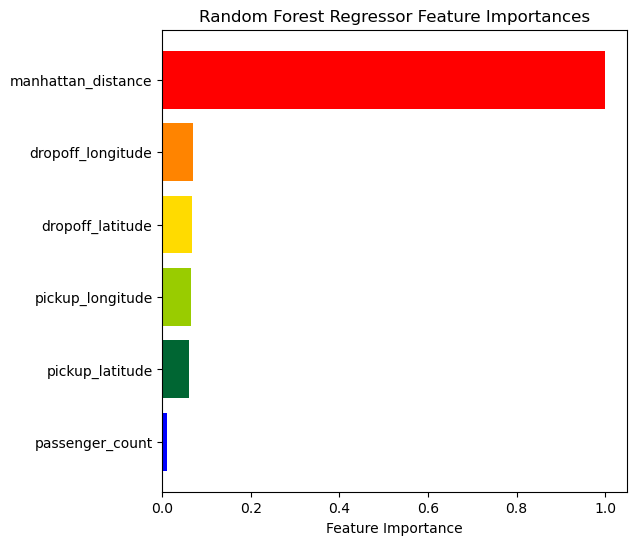

In [12]:
# plot the importances
feature_names = np.array(xtrain.columns)
importances = model.feature_importances_
importances = importances / importances.max()
sorted_idx = np.argsort(importances)
barPos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(6, 6))
plt.title("Random Forest Regressor Feature Importances")
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)
cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "green", "yellow", "orange", "red"], N=6)
plt.barh(barPos, importances[sorted_idx], align = 'center', color=cmap(barPos/barPos.max()))
plt.yticks(barPos, feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

## Loading the saved model to predict with the test dataset

In [13]:
loaded_model = load(model_file)
predicted_log_fare = loaded_model.predict(test)

In [14]:
predicted_fare = np.exp(predicted_log_fare)
predicted_fare

array([ 7.51761269,  9.42272278,  4.50613144, ..., 48.9397761 ,
       12.18858642,  6.08907717])